In [1]:
import os, sys, json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sys.path.append("..")

In [2]:
# read from json
data = None
data_path = "../../../output/prioplus-eurosys25/experiments/"
experiment_name = "fig10a"
with open(data_path + experiment_name + ".json", "r") as f:
    data = json.load(f)

In [3]:
# In this experiment, we have four flows and a bottleneck link
# Draw the send rate of each flow in subfigure1
# And draw the queue length of the bottleneck link in subfigure2

# Calculate the send rate from data{flowStatistics:[]:sentPkt:[timeNs,sizeByte]}
# The send rate is calculated by the number Bytes sent in each time interval
send_rate_interval_ns = 10e4  # 10us
# calculate the total send rate of 8 prio flows and each prio has 50 flows

flow_num = 30
prio_num = 8
send_rate = [[] for i in range(prio_num)]
for i in range(prio_num):
    wnd_start = data["flowStatistics"][i*flow_num]["sentPkt"][0]["timeNs"]
    # the first point
    send_rate[i].append({"timeNs": wnd_start, "sendRateGbps": 0})
    wnd_data = 0
    pkt_idxs = [0 for _ in range(flow_num)]
    while True:
        wnd_data = 0
        next_wnd_start = wnd_start + send_rate_interval_ns
        for j in range(flow_num):
            pkt_idx = 0
            for pkt_idx in range(pkt_idxs[j], len(data["flowStatistics"][i*flow_num + j]["sentPkt"])):
                sentPkt = data["flowStatistics"][i*flow_num + j]["sentPkt"][pkt_idx]
                if sentPkt["timeNs"] - wnd_start > send_rate_interval_ns:
                    # Gbps = bpns
                    # pkt_idxs[j] = pkt_idx - 1
                    break
                wnd_data += sentPkt["sizeByte"]
            pkt_idxs[j] = pkt_idx
        send_rate[i].append({"timeNs": wnd_start + send_rate_interval_ns/2,
                            "sendRateGbps": wnd_data * 8 / send_rate_interval_ns})
        wnd_start = next_wnd_start

        should_break = True
        for j in range(flow_num):
            if pkt_idxs[j] < len(data["flowStatistics"][i*flow_num + j]["sentPkt"]) - 1:
                should_break = False
                break
        if should_break:
            break
    # the last point
    send_rate[i].append({"timeNs": wnd_start + send_rate_interval_ns/2,
                        "sendRateGbps": 0})



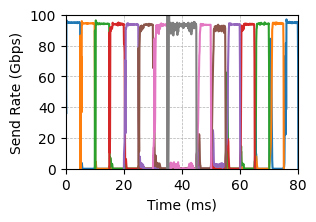

In [4]:
# draw the queue length of the bottleneck link
# draw the send rate in a new figure
fig = plt.figure(figsize=(3, 2))
ax1 = fig.add_subplot(111)
# ax.set_xlabel("Time (us)")

legend_lines = []

color_rate = ["#F44336", "#1E88E5"]
idx = {
    0: 1,
    1: 0
}
color_queue = ["#4E342E", "#FB8C00"]
line_style = ["-","--"]

time_shift = 100

ax1.grid(True, linestyle='--', linewidth=0.5, which='both', axis='both')
ax1.set_xlim(0, 80)
ax1.set_ylim(0, 100)
# hide x-axis label and ticks
# ax1.xaxis.set_tick_params(labelbottom=False)

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Send Rate (Gbps)")
for i in range(prio_num):
    ax1.plot([s["timeNs"]/1e6 - 100 for s in send_rate[i]], [s["sendRateGbps"]
             for s in send_rate[i]], label="flow"+str(i))

plt.savefig("../figures/" + "fig10a" +
            ".pdf", bbox_inches='tight', dpi=600, format='pdf')